In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

import joblib

from forecasting_bluesky_code import preprocessing as pre
from forecasting_bluesky_code import all_csv_directories as csv
from forecasting_bluesky_code import impact_score as isc
from forecasting_bluesky_code import metrics_plots as mp


# Logistic Regression: daily new users

### Dataset diario

In [6]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [7]:
df = pre.basic_proc_final_dataset(df)

In [8]:
df.columns

Index(['artificial intelligence', 'crime', 'education', 'elections',
       'entertainment', 'environment', 'finance', 'health', 'immigration',
       'international relations', 'pandemics', 'politics', 'protests',
       'science', 'sports', 'technology', 'videogames', 'war', 'tot_users',
       'new_users', 'num_likes', 'num_posts', 'num_images', 'num_follows',
       'num_blocks'],
      dtype='object')

In [9]:
# Separamos las columnas de texto para aplicarles el impact_score
df_text = df.drop(columns = df._get_numeric_data().columns)

# Separamos las columnas que serán el resto de features del modelo
df_ft = df.drop(columns = df_text.columns)

In [10]:
df_text.columns, df_ft.columns

(Index(['artificial intelligence', 'crime', 'education', 'elections',
        'entertainment', 'environment', 'finance', 'health', 'immigration',
        'international relations', 'pandemics', 'politics', 'protests',
        'science', 'sports', 'technology', 'videogames', 'war'],
       dtype='object'),
 Index(['tot_users', 'new_users', 'num_likes', 'num_posts', 'num_images',
        'num_follows', 'num_blocks'],
       dtype='object'))

### Feature Engineering para datos continuos
- PCA para las columnas de actividad.
- Series temporales: Lags (yesterday data for users, new users and activity score), Rolling Mean (7 day rolling mean data for new users and activity score), Diff.

In [12]:
df_ft = pre.activity_score_pca(df_ft)
df_ft = pre.temp_columns(df_ft, window = 4)
#df = pre.standard_scaler_num(df)

### Impact Score para las noticias
Sacamos el impact score de las noticias de 2025 para usarlo como una feature más del modelo.

In [ ]:
# 1. Pipeline para aplicar los diferentes componentes (solo 2025)
df_text_2025 = df_text.loc['01-01-2025':,:]
impact_score_array = isc.impact_score_pipeline.fit_transform(df_text_2025)

In [ ]:
# 2. Cargamos el modelo XGBoost pre-entrenado
xgb_model = joblib.load('impact_score_xgb_model.pkl')

In [13]:
# 3. Sacamos el impact_score de las noticias de 2025
impact_score_2025 = xgb_model.predict_proba(df_text_2025)[:,1]

In [14]:
# Unimos esta nueva feature al resto del dataframe

# Crear rango de fechas para el array actual
start_2025 = pd.to_datetime('2025-01-01')
end_2025 = pd.to_datetime('2025-04-07')
dates_2025 = pd.date_range(start=start_2025, end=end_2025)

# Crear el DataFrame con los datos
df_2025 = pd.DataFrame(data=impact_score_2025, index=dates_2025, columns=['impact_score'])

# Crear rango de fechas faltante (desde 2023-05-08 hasta 2024-12-31)
dates_missing = pd.date_range(start='2023-05-08', end='2024-12-31')
df_missing = pd.DataFrame(0, index=dates_missing, columns=['impact_score'])

# Concatenar ambos DataFrames
df_impact_score_2025 = pd.concat([df_missing, df_2025])

# Verificamos que todo esté ordenado por fecha
df_impact_score_2025 = df_impact_score_2025.sort_index()

In [15]:
# Concatenamos con el df completo
df_final = pd.concat([df_ft, df_impact_score_2025], axis = 1)

In [16]:
df_final

,tot_users,new_users,activity_score_pca,users_lag1,new_users_lag1,activity_lag1,new_users_ma7,activity_ma7,new_users_diff,activity_diff,impact_score
2023-05-08,31522.0,0.0,-1.650371,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000
2023-05-09,33644.5,2122.5,-1.644322,31522.0,0.0,-1.650371,0.000,0.000000,2122.5,0.006049,0.000000
2023-05-10,35767.0,2122.5,-1.647769,33644.5,2122.5,-1.644322,0.000,0.000000,0.0,-0.003446,0.000000
2023-05-11,37889.5,2122.5,-1.649415,35767.0,2122.5,-1.647769,1591.875,-1.647969,0.0,-0.001646,0.000000
2023-05-12,40012.0,2122.5,-1.646652,37889.5,2122.5,-1.649415,2122.500,-1.647039,0.0,0.002763,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03,33995137.0,90941.0,2.993873,33904196.0,47100.0,2.729988,52978.500,2.662422,43841.0,0.263885,0.509488
2025-04-04,34177832.0,182695.0,3.828071,33995137.0,90941.0,2.993873,89824.750,3.012377,91754.0,0.834198,0.082880
2025-04-05,34320771.0,142939.0,3.598483,34177832.0,182695.0,3.828071,115918.750,3.287604,-39756.0,-0.229588,0.583130
2025-04-06,34452077.0,131306.0,3.601917,34320771.0,142939.0,3.598483,136970.250,3.505586,-11633.0,0.003433,0.119040


### Target: rangos de actividad
Nuestro objetivo es predecir el rango de actividad en la red de mañana. Dividimos los rangos usando los quantiles, quedando 4 clases.

In [19]:
df_final['activity_range'] = pre.categorize_quantile(df_final, 'activity_score_pca')

In [20]:
df_final.activity_range.unique()

array([0, 1, 2, 3])

In [21]:
df_final['target'] = df_final['activity_range'].shift(-1)
df_final = df_final.fillna(0)

In [22]:
# Target
target = 'target'

# X y division
X = df_final.drop(columns=target)
y = df_final[target]

### Features del modelo
- **tot_users**: el total de usuarios agregado por día
- **new_users**: el total de nuevos usuarios diario
- **activity_score_pca**: principal components analysis (score de -1.7 a 8.7)
- **Impact Score**: impacto de las noticias en el crecimiento de la actividad en la red
- **Target**: rango de actividad que habrá al día siguiente

#### Exportar datos

In [63]:
df_final.to_csv('daily_dataset_model_features_class.csv')

## Classification Model

#### Train-Test Split

In [26]:
total_reg = len(df_final.index)
test_size_reg = 0.30

total_test = round(total_reg*test_size_reg)
total_train = total_reg-total_test

total_test, total_train

(210, 491)

Fechas train : 2023-05-08 00:00:00 --- 2024-09-09 00:00:00  (n=491)
Fechas test  : 2024-09-10 00:00:00 --- 2025-04-07 00:00:00  (n=210)


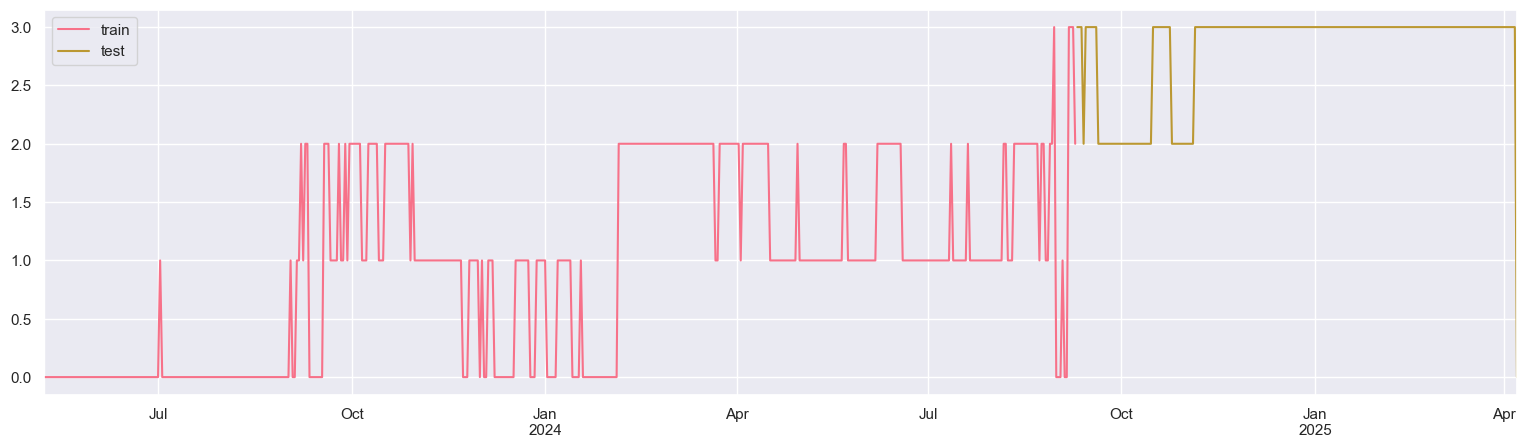

In [27]:
# Separación datos train-test
# Se usan los últimos *total_test días para testear el modelo
# ==============================================================================
steps = total_test
datos_train = df_final[:-steps]
datos_test  = df_final[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(19, 5))
datos_train[target].plot(ax=ax, label='train')
datos_test[target].plot(ax=ax, label='test')
ax.legend();

In [28]:
X_train = datos_train.drop(columns = target)
y_train = datos_train[target]

X_test = datos_test.drop(columns = target)
y_test = datos_test[target]

#### LogisticRegression

In [30]:
# Definición del modelo
model = LogisticRegression()

# Para escalar los datos
scaler = StandardScaler()

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

In [31]:
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [32]:
# Entrenamos el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [33]:
# Predicciones sobre el conjunto de train
y_pred_train = pipeline.predict(X_train)
# Predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo train
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")

# Evaluar el modelo test
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")



TRAIN
  Accuracy: 0.87
  Report:               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       175
         1.0       0.83      0.83      0.83       175
         2.0       0.84      0.85      0.84       137
         3.0       1.00      0.50      0.67         4

    accuracy                           0.87       491
   macro avg       0.90      0.78      0.82       491
weighted avg       0.87      0.87      0.87       491

TEST
  Accuracy: 0.89
  Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         2.0       0.66      0.87      0.75        38
         3.0       0.96      0.90      0.93       171

    accuracy                           0.89       210
   macro avg       0.54      0.59      0.56       210
weighted avg       0.90      0.89      0.89       210



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


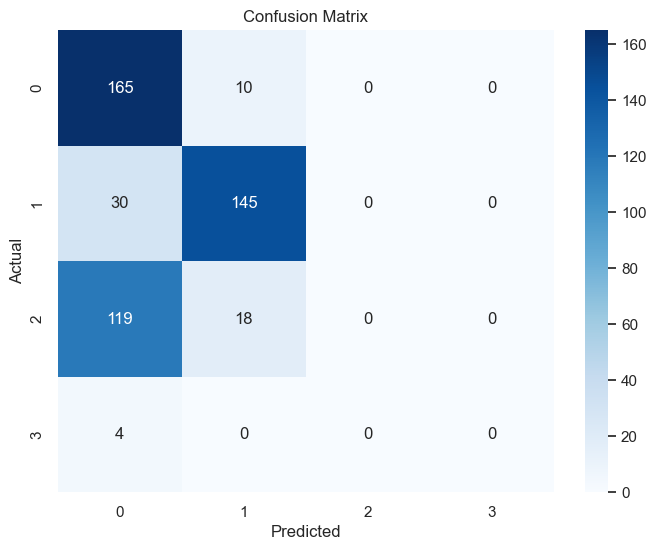

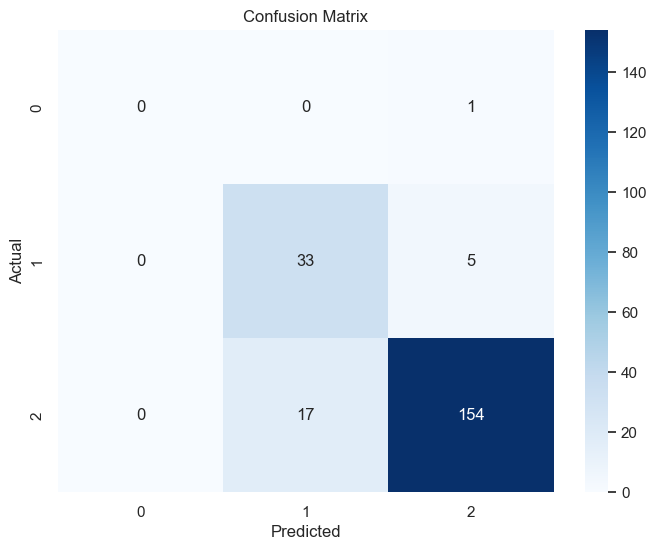

In [63]:
mp.confusion_matrix_plot(y_pred_train,y_train,save=True,filename='confusion-matrix-train')
mp.confusion_matrix_plot(y_pred,y_test,save=True)

In [57]:
# Entrenamos el modelo con todo el set de datos
pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [59]:
# Guardamos el modelo ya entrenado como .pkl para poder usarlo en el deployment
joblib.dump(pipeline, 'logistic_reg_bsky.pkl')

['logistic_reg_bsky.pkl']

# Linear Regression: weekly new users

### Dataset semanal

In [73]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [75]:
df = pre.basic_proc_final_dataset(df)

In [77]:
df_weekly = pre.generate_weekly_df(df)

In [83]:
# Separamos las columnas de texto para aplicarles el impact_score
df_text_weekly = df_weekly.drop(columns = df_weekly._get_numeric_data().columns)

# Separamos las columnas que serán el resto de features del modelo
df_ft_weekly = df_weekly.drop(columns = df_text_weekly.columns)

### Feature Engineering para datos continuos
- PCA para las columnas de actividad.
- Series temporales: Lags (yesterday data for users, new users and activity score), Rolling Mean (7 day rolling mean data for new users and activity score), Diff.

In [90]:
df_ft_weekly = pre.activity_score_pca(df_ft_weekly)
df_ft_weekly = pre.temp_columns(df_ft_weekly, window = 4)

### Impact Score para las noticias
Sacamos el impact score de las noticias de 2025 para usarlo como una feature más del modelo.

In [ ]:
# 1. Pipeline para aplicar los diferentes componentes (solo 2025)
df_text_2025 = df_text_weekly.loc['01-01-2025':,:]
impact_score_array = isc.impact_score_pipeline.fit_transform(df_text_2025)

In [ ]:
# 2. Cargamos el modelo XGBoost pre-entrenado
xgb_model_weekly = joblib.load('impact_score_xgb_model_weekly.pkl')

In [13]:
# 3. Sacamos el impact_score de las noticias de 2025
impact_score_2025 = xgb_model_weekly.predict_proba(df_text_2025)[:,1]

In [14]:
# Unimos esta nueva feature al resto del dataframe

# Crear rango de fechas para el array actual
start_2025 = pd.to_datetime('2025-01-01')
end_2025 = pd.to_datetime('2025-04-07')
dates_2025 = pd.date_range(start=start_2025, end=end_2025)

# Crear el DataFrame con los datos
df_2025 = pd.DataFrame(data=impact_score_2025, index=dates_2025, columns=['impact_score'])

# Crear rango de fechas faltante (desde 2023-05-08 hasta 2024-12-31)
dates_missing = pd.date_range(start='2023-05-08', end='2024-12-31')
df_missing = pd.DataFrame(0, index=dates_missing, columns=['impact_score'])

# Concatenar ambos DataFrames
df_impact_score_2025 = pd.concat([df_missing, df_2025])

# Verificamos que todo esté ordenado por fecha
df_impact_score_2025 = df_impact_score_2025.sort_index()

In [15]:
# Concatenamos con el df completo
df_final_weekly = pd.concat([df_ft_weekly, df_impact_score_2025], axis = 1)

### Target: rangos de actividad
Nuestro objetivo es predecir el rango de actividad en la red de la próxima semana.

In [106]:
df_final_weekly['activity_range'] = pre.categorize_quantile(df_final_weekly, 'activity_score_pca')

In [108]:
df_final_weekly.activity_range.unique()

array([0, 1, 2, 3])

In [110]:
df_final_weekly['target'] = df_final_weekly['activity_range'].shift(-1)
df_final_weekly = df_final_weekly.fillna(0)

In [112]:
# Target
target = 'target'

# X y division
X = df_final_weekly.drop(columns=target)
y = df_final_weekly[target]

### Features del modelo
- **tot_users**: el total de usuarios agregado por día
- **new_users**: el total de nuevos usuarios diario
- **activity_score_pca**: principal components analysis (score de -1.7 a 8.7)
- **Impact Score**: impacto de las noticias en el crecimiento de la actividad en la red
- **Target**: rangos de actividad de la próxima semana

## Classification Model

#### Train-Test Split

In [133]:
total_reg = len(df_final_weekly.index)
test_size_reg = 0.20

total_test = round(total_reg*test_size_reg)
total_train = total_reg-total_test

total_test, total_train

(20, 81)

Fechas train : 2023-05-14 00:00:00 --- 2024-11-24 00:00:00  (n=81)
Fechas test  : 2024-12-01 00:00:00 --- 2025-04-13 00:00:00  (n=20)


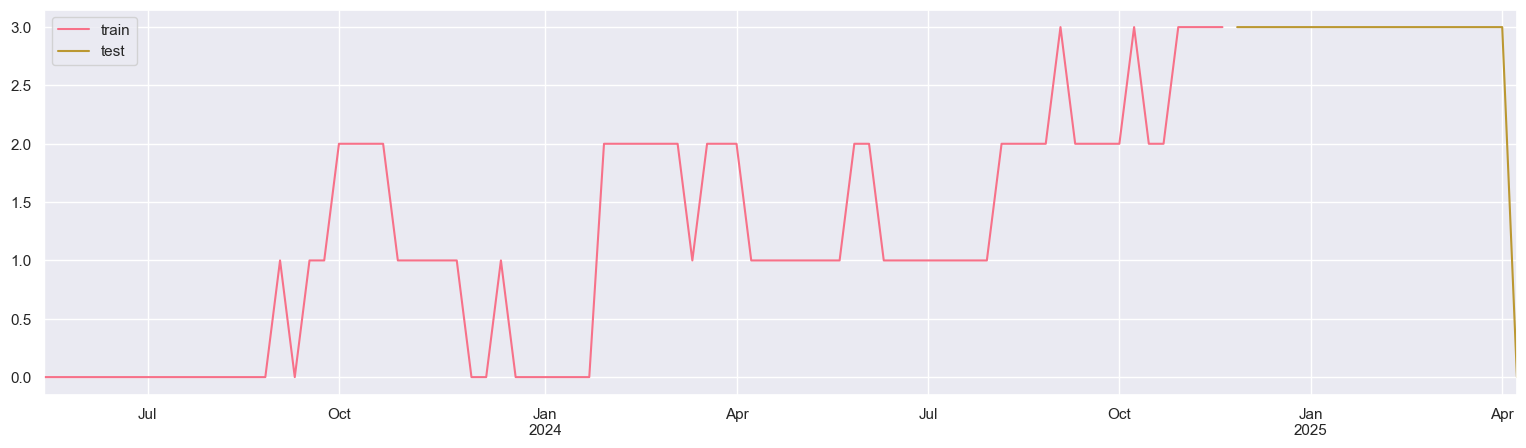

In [135]:
# Separación datos train-test
# Se usan los últimos *total_test días para testear el modelo
# ==============================================================================
steps = total_test
datos_train = df_final_weekly[:-steps]
datos_test  = df_final_weekly[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(19, 5))
datos_train[target].plot(ax=ax, label='train')
datos_test[target].plot(ax=ax, label='test')
ax.legend();

In [137]:
X_train = datos_train.drop(columns = target)
y_train = datos_train[target]

X_test = datos_test.drop(columns = target)
y_test = datos_test[target]

#### LogisticRegression

In [141]:
# Definición del modelo
model_weekly = LogisticRegression()

# Para escalar los datos
scaler = StandardScaler()

# Pipeline
pipeline_weekly = Pipeline([
    ('scaler', scaler),
    ('model_weekly', model_weekly)
])

In [143]:
pipeline_weekly

Pipeline(steps=[('scaler', StandardScaler()),
                ('model_weekly', LogisticRegression())])

In [145]:
# Entrenamos el modelo
pipeline_weekly.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model_weekly', LogisticRegression())])

In [147]:
# Predicciones sobre el conjunto de train
y_pred_train = pipeline_weekly.predict(X_train)
# Predicciones sobre el conjunto de prueba
y_pred = pipeline_weekly.predict(X_test)

# Evaluar el modelo train
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train)

print('TRAIN')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")

# Evaluar el modelo test
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('TEST')
print(f"  Accuracy: {accuracy:.2f}")
print(f"  Report: {report}")



TRAIN
  Accuracy: 0.80
  Report:               precision    recall  f1-score   support

         0.0       0.82      0.92      0.87        25
         1.0       0.74      0.68      0.71        25
         2.0       0.80      0.80      0.80        25
         3.0       1.00      0.83      0.91         6

    accuracy                           0.80        81
   macro avg       0.84      0.81      0.82        81
weighted avg       0.80      0.80      0.80        81

TEST
  Accuracy: 0.95
  Report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         3.0       0.95      1.00      0.97        19

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


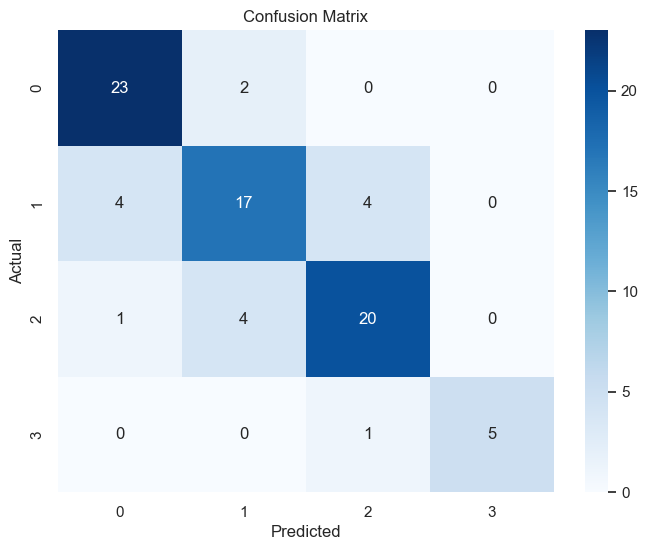

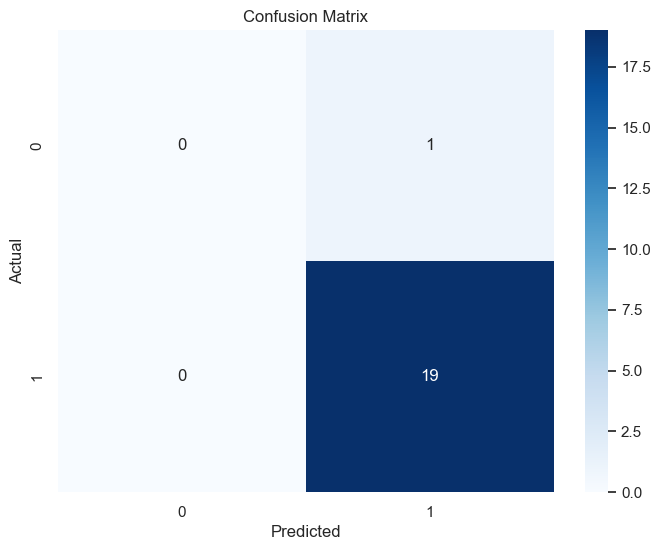

In [149]:
mp.confusion_matrix_plot(y_pred_train,y_train,save=True,filename='confusion-matrix-train')
mp.confusion_matrix_plot(y_pred,y_test,save=True)